In [1]:
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Pauli
from qiskit.circuit.library import HamiltonianGate, UnitaryGate
import numpy as np
pi = np.pi

from qiskit.primitives import StatevectorEstimator
estimator_exact = StatevectorEstimator()

from IPython.display import clear_output
import matplotlib.pyplot as plt

from circuit_functions import ki_circ_as_list, bm_circ_as_list, gates_list_to_qc, single_qubit_pauli_rotation_in_generic_form
from circuit_functions import two_qubit_pauli_rotation_in_generic_form, gates_list_to_transpiled_circuit, connected_qubits

In [2]:
coupling_map = np.load('calibration_data/coupling_map.npy')

# Set parameters

In [3]:
num_qubits = 16

# central_qubit = 62
# device_qubits = list([central_qubit])
# for i in range(num_qubits-1):
#     connected_qubits_list = []
#     for q in device_qubits:
#         connected_qubits_list = connected_qubits_list + connected_qubits(q, coupling_map)
#     connected_qubits_list = [q for q in connected_qubits_list if q not in device_qubits]
#     new_qubit = np.random.choice(connected_qubits_list)
#     device_qubits.append(new_qubit)

device_qubits = [62, 61, 60, 53, 59, 72, 63, 58, 71, 77, 64, 41, 57, 40, 39, 81]
print('device_qubits =', device_qubits)

circuit_layers = [1,5,10,15,20]

Ls = np.load('calibration_data/layers.npy')
gate_layers = [[],[],[]]
for i in range(3):
    for q0, q1 in Ls[i]:
        if q0 in device_qubits and q1 in device_qubits:
            gate_layers[i].append([device_qubits.index(q0), device_qubits.index(q1)])

nearest_neighbour_layers = gate_layers

num_benchmarking_reps = 10
observable = 'I'*device_qubits.index(62) + 'Z' + 'I'*(num_qubits-device_qubits.index(62)-1)
observable = observable[::-1]

qubits_to_correct = [device_qubits.index(62)]

device_qubits = [62, 61, 60, 53, 59, 72, 63, 58, 71, 77, 64, 41, 57, 40, 39, 81]


# Circuit generation

In [4]:
ki_circs_list = []
for i in range(5):
    ki_gates_list = ki_circ_as_list(num_qubits, circuit_layers[i], nearest_neighbour_layers, 0.01, 0.01, qubits_to_correct)
    ki_trans = gates_list_to_transpiled_circuit(ki_gates_list, num_qubits)
    ki_circs_list.append(ki_trans)
    
    clear_output(wait=True)
    print(i)
clear_output(wait=True)
print('Done!')

Done!


In [5]:
# bm_circs_list = [[],[],[],[],[]]
# for i in range(5):
#     for j in range(10):
#         bm_gates_list = bm_circ_as_list(num_qubits, circuit_layers[i], nearest_neighbour_layers, qubits_to_correct)
#         bm_trans = gates_list_to_transpiled_circuit(bm_gates_list, num_qubits)
#         bm_circs_list[i].append(bm_trans)
        
#         clear_output(wait=True)
#         print(i,j)
clear_output(wait=True)
print('Done!')

Done!


# Exact simulation of KI circuits

In [6]:
ki_exact_vals = [estimator_exact.run([(ki, observable)]).result()[0].data.evs for ki in ki_circs_list]
print(ki_exact_vals)

[array(0.99995), array(0.99875251), array(0.99504108), array(0.98895765), array(0.98065146)]


# Our benchmarking on hardware

In [7]:
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2

# service = QiskitRuntimeService(
#     channel='ibm_quantum',
#     instance='',
#     token=''
# )

hardware = service.backend('ibm_brisbane')

In [8]:
# 'Transpile' observable
observable_trans = 'I'*62 + 'Z' + 'I'*(127-62-1)
observable_trans = observable_trans[::-1]

In [9]:
# Transpile kicked Ising circuits for hardware
ki_circs_list_trans = []
for qc in ki_circs_list:
    qc_trans = transpile(qc, hardware, initial_layout=device_qubits, optimization_level=0)
    ki_circs_list_trans.append(qc_trans)

In [10]:
# Transpile benchmarking circuits for hardware
bm_circs_list_trans = []
for i in range(5):
    for j in range(10):
        qc = bm_circs_list[i][j]
        qc_trans = transpile(qc, hardware, initial_layout=device_qubits, optimization_level=0)
        bm_circs_list_trans.append(qc_trans)

        clear_output(wait=True)
        print(i,j)

4 9


In [11]:
circs_to_submit = ki_circs_list_trans + bm_circs_list_trans

In [12]:
len(circs_to_submit) == 55 # 5 KI + 5*10 BM

True

In [13]:
# Submit to hardware:

from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
pm = generate_preset_pass_manager(optimization_level=0, backend=hardware)
circs_to_submit = [pm.run(qc) for qc in circs_to_submit]

# estimator_hardware = EstimatorV2(mode=hardware)
# job = estimator_hardware.run([(qc, observable_trans) for qc in circs_to_submit])
# print(job.job_id())

In [14]:
# Fetch job results and save them

# result = job.result()
# hardware_noisy_vals = [abs(float(x.data.evs)) for x in result] 
# np.save('mar12.npy', hardware_noisy_vals)

# Import and combine job data

In [15]:
data1 = list(np.load('job_data/16q_jan30.npy'))
ki1, bm1 = data1[:5], data1[5:]

data2 = list(np.load('job_data/16q_mar10.npy'))
ki2, bm2 = data2[:5], data2[5:]

data3 = list(np.load('job_data/16q_mar12.npy'))
ki3, bm3 = data3[:5], data3[5:]

In [16]:
kis = [ki1, ki2, ki3]
kis_avgs = [np.mean([kis[i][j] for i in range(3)]) for j in range(5)]
kis_stds = [np.std([kis[i][j] for i in range(3)]) for j in range(5)]
kis_yerr = [kis_stds, kis_stds]

In [17]:
bms = [bm1, bm2, bm3]
bms_avgs = []
bms_stds = []
for i in range(5):
    bm_list = []
    for j in range(3):
        bm_list += bms[j][i*num_benchmarking_reps:(i+1)*num_benchmarking_reps]
    bms_avgs.append(np.mean(bm_list))
    bms_stds.append(np.std(bm_list))

bms_yerr = [bms_stds, bms_stds]

# RB prediction using hardware data

In [18]:
from rb_prediction import estimate_rb_fidelity
filenames = [
    'ibm_brisbane_calibrations_2025-01-30T09_58_43Z.csv',
    'ibm_brisbane_calibrations_2025-03-10T08_32_38Z.csv',
    'ibm_brisbane_calibrations_2025-03-12T15_19_10Z.csv'
]
rbs = []
for file in filenames:
    rb_fidelities = [estimate_rb_fidelity(qc, 'calibration_data/'+file, device_qubits, measured_qubits=[device_qubits.index(62)]) for qc in ki_circs_list]
    rbs.append(rb_fidelities)

In [19]:
rbs_avgs = [np.mean([rbs[i][j] for i in range(3)]) for j in range(5)]
rbs_stds = [np.std([rbs[i][j] for i in range(3)]) for j in range(5)]
rbs_yerr = [rbs_stds, rbs_stds]

# Plot results

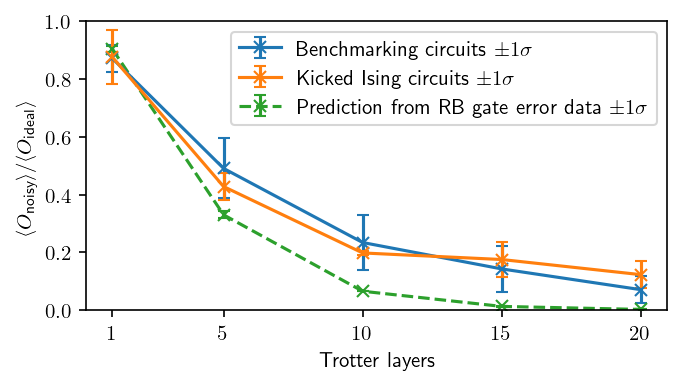

In [20]:
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath} \usepackage{amssymb}'

plt.figure(dpi=150, figsize=(5,2.5))

plt.errorbar(circuit_layers, rbs_avgs, yerr=rbs_yerr, marker='x', color='tab:green', linestyle='--', capsize=3, label=r'Prediction from RB gate error data $\pm 1\sigma$')
plt.errorbar(circuit_layers, bms_avgs, yerr=bms_yerr, marker='x', color='tab:blue', capsize=3, label=r'Benchmarking circuits $\pm 1\sigma$')
plt.errorbar(circuit_layers, kis_avgs, yerr=kis_yerr, marker='x', color='tab:orange', capsize=3, label=r'Kicked Ising circuits $\pm 1\sigma$')

plt.xlabel('Trotter layers')
plt.ylabel(r'$ \langle O_\text{noisy} \rangle / \langle O_\text{ideal} \rangle$')

handles, labels = plt.gca().get_legend_handles_labels() 
order = [1,2,0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
plt.ylim([0,1])
plt.xticks([1,5,10,15,20])

plt.show()